<a href="https://colab.research.google.com/github/jzinnegger/mlrisk/blob/main/MyTF2DifferentialML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working paper: https://arxiv.org/abs/2005.02347 
GitHub: https://github.com/differential-machine-learning

# Imports

In [14]:

# import and test
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


# import other useful libs
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook
from tqdm.keras import TqdmCallback
# print(f"tqdm version:{tqdm.__version__}")

from scipy import stats

from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras import layers

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64
import datetime             

%load_ext tensorboard

2.3.0
[]
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
# Tensorflow Technologies

# Overview Tensorflow documentation


## Tensor Flow Basics - more educational

Summary of the Tensor flow basis chapters: [Guide Eager Execution](https://www.tensorflow.org/guide/eager): Basic low level implementation of all components. Principles only. 

[Introduction to modules, layers, and models](https://www.tensorflow.org/guide/intro_to_modules)

[Basic Training Loops](https://www.tensorflow.org/guide/basic_training_loops)

## Keras - boilerplate examples

[Guide: The Functional API](https://www.tensorflow.org/guide/keras/functional). Functional API for non-sequential inputs in backward layer. 

[Guide: Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models). Includes layers inside the custom layer.

[Guide: Training and evaluation with the built-in methods](https://www.tensorflow.org/guide/keras/train_and_evaluate) introduces standard Keras components. Including [custom metrics](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_metrics) (loss functions).


[Guide: Customize what happens in Model.fit](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit). Subclassing models with customized functions for `train_step()` and `metric()`, while using the standard model fit procedure. Requires the expilict use of gradient tape.

[Guide: Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) goes beyond customizing the fit function. Define explicit loops over epoch and batches.




# Part I: Illustration of learning objective with pathwise payouts and deltas

As a first, and somewhat compulsory example, we learn the pricing and risk function of a European call in Black & Scholes' classic model of 1973, training on simulated LSM samples and verifying performance against the correct pricing function, given by Black & Scholes formula.

The simple code below generates a training set of LSM samples, along with pathwise differentials, and a test set of true prices and risks computed in closed form.

The implementation is a fast, vectorized Monte-Carlo simulation in numpy. Code should be self explanatory, safe for two maybe unusual features. **We allow raising volatility by a factor *volMult* between now (time $0$) and the pricing date $T_1$ to get more samples on the wings and better learn asymptotics.** Our labels may also represent *the average of two antithetic samples* instead of one, which reduces variance for an acceptable cost in this simple case. 

Pathwise differentials are easily computed in Black & Scholes, where:

$$
    S_{T_2} = S_{T_1} exp \left[ - \frac{\sigma^2}{2} \left( {T_2} - {T_1} \right) + \sigma \left( W_{T_2} - W_{T_1} \right)  \right]
$$

so

$$
    \frac { \partial \left( S_{T_2} - K  \right)^+} {\partial S_{T_1}} = 1_{\left\{S_{T_2} > K\right\}} \frac{S_{T_2}}{S_{T_1}}
$$



In [16]:
# helper analytics    
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
#
    
# main class
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10, 
                 volMult=1.5):        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
        self.X = np.array([])
        
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None, reggrid=False):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        
        # regular grid
        if reggrid:

          # domain specific range
          lower=0.35   # or 1 for ATM
          upper=1.65
          R1 = np.linspace(lower, upper, m)
          # normal
          # R1 = np.random.normal(1, 0.6, size=m)
        else:
          R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 


        # shuffle paths (X,Y,Z) jointly with scikit-learn 
        # in case initial states are not random (e.g. a linear sequence)
        # X, Y, Z = shuffle(X, Y, Z, random_state=0)

        self.X = X
        
   
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    # training is on sampled (LSM style) spots S1, while test set in on linspace spots S1 
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):

        xTrainKde = {}
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))


        # kernel density of train data evaluated at test grid
        # for size in sizes:
        #  gkde=stats.gaussian_kde(self.X.reshape(-1), bw_method='silverman')
        #  xTrainKde[(size)] = gkde.evaluate(spots.reshape(-1))

        return spots, spots, prices, deltas, vegas

In [17]:
# simulation set sizes to perform
sizes = [1024, 8192]
size = sizes[1]

# show delta?
showDeltas = False

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)


# number of test scenarios
nTest = 100    

# pick one delta for illustration
deltidx=0

# go
generator = BlackScholes()
print("simulating training, valid and test sets")
# generator receives max size only (training will be performed on subsets if training size > max size)
xTrain, yTrain, dydxTrain = generator.trainingSet(size, anti = True, seed=simulSeed)
xTest, xAxis, yTest, dydxTestFull, vegas  = generator.testSet(num=nTest, seed=None)
print("done")

dydxTest = dydxTestFull[:, deltidx]



using seed 7457
simulating training, valid and test sets
done


Illustrate training data

In [18]:
xTrain.shape

(8192, 1)

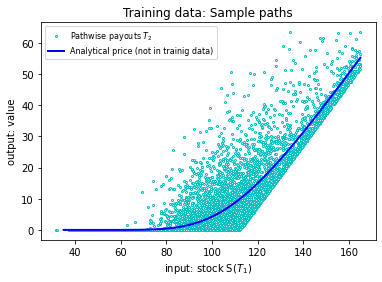

In [19]:
#@title
fig, ax = plt.subplots()

ax.set(xlabel='input: stock S($T_1$)', ylabel='output: value',
       title='Training data: Sample paths')

# simultated input paths vs BS ground truth
# xp = xTrain[0:6000]
# yp = yTrain[0:6000]
xp=xTrain
yp=yTrain
xlim = np.max(xAxis)
ylim = np.max(yTest)
xAxisSorted, yTestSorted = zip(*sorted(zip(xAxis.reshape(-1), yTest.reshape(-1))))
ax.plot(xp[(xp<xlim)&(yp<ylim*1.2)]*100, yp[(xp<xlim)&(yp<ylim*1.2)]*100, 'co', markersize=2, markerfacecolor='white', label="Pathwise payouts $T_2$")
ax.plot(np.array(xAxisSorted)*100,np.array(yTestSorted)*100, 'b-', linewidth=2, label='Analytical price (not in trainig data)')

#ax.plot(xAxis*100, yTest*100, 'r.', markersize=1.5, label='Analytical price (not in trainig data)')

ax.margins(0.05, 0.05)
ax.legend(prop={'size': 8}, loc='upper left')


plt.show()


In [20]:
xAxisSorted, dydxTestSorted = zip(*sorted(zip(xAxis.reshape(-1), dydxTest.reshape(-1))))

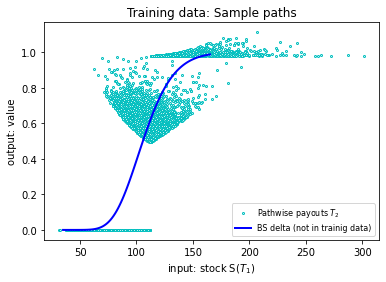

In [21]:
#@title
fig, ax = plt.subplots()

ax.set(xlabel='input: stock S($T_1$)', ylabel='output: value',
       title='Training data: Sample paths')

# simultated input paths vs BS ground truth
# xp = xTrain[0:2000]
# yp = dydxTrain[0:2000]
xp = xTrain
yp = dydxTrain
# xlim = np.max(xAxis)
# ylim = np.max(dydxTest)
ax.plot(xp*100, yp, 'co', markersize=2, markerfacecolor='white', label="Pathwise payouts $T_2$")
# ax.plot(xp[(xp<xlim)&(yp<ylim*1.2)]*100, yp[(xp<xlim)&(yp<ylim*1.2)]*100, 'co', markersize=2, markerfacecolor='white', label="Pathwise payouts $T_2$")
xAxisSorted, dydxTestSorted = zip(*sorted(zip(xAxis.reshape(-1), dydxTest.reshape(-1))))
ax.plot(np.array(xAxisSorted)*100, np.array(dydxTestSorted), \
       'b-', linewidth=2, label='BS delta (not in trainig data)')

ax.margins(0.05, 0.05)
# ax.legend(prop={'size': 8}, loc='lower right')

ax.legend(prop={'size': 8})

plt.show()


# Part II : Core Functions

## Feedforward neural network in TensorFlow

Create a feedforward network with the Keras functional interface

In [22]:
MAX_EPOCHS = 100
MIN_BATCH_SIZE = 256
STEPS_PER_EPOCH = 16

print(f"data sizes {sizes}")
print(f"implied batch sizes {np.array(sizes)/STEPS_PER_EPOCH}")
print(f"default min batch size {256}")
print(f"implied steps per epoch {np.array(sizes)/256}")

data sizes [1024, 8192]
implied batch sizes [ 64. 512.]
default min batch size 256
implied steps per epoch [ 4. 32.]


### High-level abstraction with standard Keras Dense layers

In [23]:
def build_forward_model(
    input_dim,          # dimension of test data values + number of sensitivities
    seed=None    # re-initialiaze trained model for next training
    ):
  
  # set seed
  tf.random.set_seed(seed)

  # model layout parameters
  hidden_units = 20   # units in hidden layers, standard in 
  hidden_layers = 6  # number of hidden layers, standard in 

  # weight initialization function and parameters
  initializer = tf.keras.initializers.GlorotNormal()
  
  # initalize normalisation layer
  input_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[input_dim,])
  
  # optimizer
  optimizer = tf.keras.optimizers.Adam()


  # model layout
  zs = []

  input = keras.Input(shape=(input_dim,))
  gzl = input_normalizer(input)
  for l in np.arange(1,hidden_layers):
    zl = layers.Dense(hidden_units, activation=None, kernel_initializer=initializer)(gzl)
    gzl = tf.keras.activations.softplus(zl)
    
    zs.append(zl) # memorize outputs of hidden layers for backpropagation equation (2)
  
  output = layers.Dense(1, activation=None, kernel_initializer=initializer)(gzl)     
  
  forward_model = tf.keras.Model(inputs=input, outputs=output)
 
  # model creation
  forward_model.compile(
      optimizer=optimizer,
      loss='mean_absolute_error',
      metrics=['mse']
      )
  
  return forward_model, zs

#### Backprop Layer

Backpropagation
$$ 
\bar{z}_{L} = \bar{y} = 1
$$

$$
\bar{z}_{l-1} = \left( \bar{z}_l w_l^T \right) \circ g'_{l-1}\left(z_{l-1}\right) , l=L,\dots,1
$$

$$ 
\bar{x}=  \bar{z}_{0}
$$


with $\circ$ the elementwise product (``tf.math.multiply`` or ``*`` Operator in tensorflow)






In [24]:
# custom layer for backprop (equation 2)
class BackpropDense(tf.keras.layers.Layer):
    def __init__(self, reference_layer):
      super(CustomDense, self).__init__()
      self.ref_layer = reference_layer

    def call(self, zbar, z):
        w = tf.transpose(self.weights[0]) # weights of forward net in layer l
        zbar = tf.matmul(zbar, w) * tf.math.sigmoid(z)
        return zbar

### Low Low level abstraction tf.tensors 

In [25]:
class FwdLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_units=2, hidden_layers=4, seed=None):
        super(FwdLayer, self).__init__()
        self.units = hidden_units
        self.hidden_layers = hidden_layers
        self.seed = seed


    def build(self, input_shape):
        # indices according to equation 2, starting with 1 for first layer
        w_init = tf.keras.initializers.GlorotNormal(self.seed)
        self.w1 = tf.Variable(
            initial_value=w_init(shape=(input_shape[-1], self.units),
                             dtype='float32'),
            trainable=True)

        self.wl = tf.Variable(
            initial_value=w_init(shape=(self.units, self.units, self.hidden_layers),
                             dtype='float32'),
            trainable=True)
        
        self.wL = tf.Variable(
            initial_value=w_init(shape=(self.units, 1),
                             dtype='float32'),
            trainable=True)

        self.b1 = self.add_weight(
                shape=(self.units, ),
                initializer="zeros", 
                trainable=True
            )
        self.bl = self.add_weight(
                shape=(self.units,self.hidden_layers, ),
                initializer="zeros", 
                trainable=True
            )
        self.bL = self.add_weight(
                shape=(1, ),
                initializer="zeros", 
                trainable=True
            )

    def call(self, inputs):
      
      zl = tf.matmul(inputs, self.w1) + self.b1
      gzl = tf.keras.activations.softplus(zl)
      
      # re-index the inner 'hidden' layers 2,..,L to 0,..,L-1 ()
      for l in range(0,self.hidden_layers):
          zl = tf.matmul(gzl, self.wl[:,:,l]) + self.bl[:,l]
          gzl = tf.keras.activations.softplus(zl)
      
      zl =  tf.matmul(gzl, self.wL) + self.bL

      return zl

def build_forward_model(
    input_dim,          # dimension of test data values + number of sensitivities
    seed=None    # re-initialiaze trained model for next training
    ):
  
  # set seed
  tf.random.set_seed(seed)

  # model layout parameters
  hidden_units = 20   # units in hidden layers, standard in 
  hidden_layers = 4  # number of hidden layers, standard in 

  
  # initalize normalisation layer
  input_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[input_dim,])
  
  # optimizer
  optimizer = tf.keras.optimizers.Adam()


  # model layout
  
  input = keras.Input(shape=(input_dim,))
  normalized = input_normalizer(input)
  output = FwdLayer(hidden_units,hidden_layers,seed)(normalized)

  forward_model = tf.keras.Model(inputs=input, outputs=output)
 
  # model creation
  forward_model.compile(
      optimizer=optimizer,
      loss='mean_absolute_error',
      metrics=['mse']
      )
  
  return forward_model




### Low level abstraction

Forward equation for dense layer
$$ 
\begin{align*}
z_{0} &= x&\\
z_{l} &= g_{l-1}(z_{l-1})w_{l}+b_{l}&,    l=1,\dots,L\\
y &=  z_{L}&\\
\end{align*}
$$



Backward equation:

$$ 
\begin{align*}
\bar{z}_{L} &= \bar{y} = 1&,l=L\\
\bar{z}_{l-1} &= \left( \bar{z}_l w_l^T \right) \circ g'_{l-1}\left(z_{l-1}\right) &, l=L,\dots,1\\
\bar{x} &=  \bar{z}_{0}&\\
\end{align*}
$$


with $\circ$ the elementwise product (``tf.math.multiply`` or ``*`` operator in tensorflow)


In [26]:
class FwdBckwdLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_units=20, hidden_layers=4, seed=None):
        super(FwdBckwdLayer, self).__init__()
        self.units = hidden_units
        self.hidden_layers = hidden_layers
        self.seed = seed
        self.w = []
        self.b = []
        self.w_init = tf.keras.initializers.GlorotNormal()


    def build(self, input_shape):

        # set seed
        tf.random.set_seed(self.seed)
        
        # l=0 initialize input layer
        l=0
        self.w.append( self.add_weight(f'w{l}', (input_shape[-1], self.units), \
                    'float32', self.w_init, None, trainable=True))
        self.b.append(self.add_weight(f'b{l}', (self.units, ), \
                          'float32', 'zeros', None, trainable=True))
    
        # l=1,..,L initialize hidden layers
        for _ in range(0,self.hidden_layers):
            l = l+1
            self.w.append(self.add_weight(f'w{l}', (self.units, self.units), \
                                           'float32', self.w_init, None, trainable=True))
            self.b.append(self.add_weight(f'b{l}', (self.units, ),'float32', \
                                          'zeros', None, trainable=True))

        # l=L+1 initialize output layer
        l=l+1
        self.w.append(self.add_weight(f'w{l}', (self.units, 1), \
                    'float32', self.w_init, None, trainable=True))
        self.b.append(self.add_weight(f'b{l}', (1, ), \
                    'float32', 'zeros', None, trainable=True))
        
    
 
    def call(self, inputs):
        # feed forward (for LSM prediction on discounted payouts)
        # autograph rolls out the python control flow into static tf graph 
 
        zs = []
      
        # input layer l=0
        l=0
        zl = tf.matmul(inputs, self.w[l]) + self.b[l]
        gzl = tf.keras.activations.softplus(zl)
        zs.append(zl)
      

        # hidden layers l=1,..,L
        # python for-loop (range vs. tf.range) for static graph construction
        for _ in range(0,self.hidden_layers):
            l=l+1
            zl = tf.matmul(gzl, self.w[l]) + self.b[l]
            gzl = tf.keras.activations.softplus(zl)
            zs.append(zl)

        # l = L+1 output layer w/o activation
        l=l+1
        zl =  tf.matmul(gzl, self.w[l]) + self.b[l]
        zs.append(zl) # replaced in backprop by tf.ones
        
        # return zl
        xbar = self.backprop(zs)

        return zl, xbar

    def backprop(self, zs):
        # partial derivatives obtained by explicit backpropagation
        # implemented as 'twin'-feedforward network with shared weights

        last = len(zs) - 1 # index of last element
        zbar = tf.ones_like(zs[last]) # zbar_L = 1
        for l in range(last, 0, -1):
            zbar = tf.matmul(zbar, tf.transpose(self.w[l])) * tf.keras.activations.sigmoid(zs[l-1])
        # for l=0
        zbar = tf.matmul(zbar, tf.transpose(self.w[0])) 

        xbar = zbar # xbar = zbar_0

        return xbar

### Potential Exenstions: Deep wide model

Maybe to extend the model with of the shelf[ deep wide model](https://www.tensorflow.org/api_docs/python/tf/keras/experimental/WideDeepModel)

Cabe we use the [FourierFeature](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/RandomFourierFeatures) Layer as linear layer

can we replace the backward layer by a generic backward layer using autodiff and tape on all of the dense layers including the loss function of the dense layers. See https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#create_a_tfdatadataset




Custom implementation of the mean square error term for the differential labels: The normalisation weights $\lambda_j$ for the mean square error ${mse}_j$ of derivatives to input $j$ is passed as an additional parameter and requires subclassing the loss function (see [custom losses](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)).

In [86]:
class WeightedMSE(keras.losses.Loss):
# scale prediction error for each output (derivative) by L2 norm to level MSE contribution
    def __init__(self, norm_weights = None, name="mse_weighted"):
        super().__init__(name=name)
        self.norm_weights = norm_weights

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square((y_true  - y_pred) * self.norm_weights))
        return mse
    
    def adapt(self, dydx):
        # lambda_j = 1.0 / np.sqrt((dydx ** 2).mean(axis=0)).reshape(1, -1)
        lambda_j = 1.0 / tf.reshape(tf.reduce_mean(tf.sqrt(dydx * dydx),axis=0),[1,-1])
        self.norm_weights = lambda_j

In [28]:
def build_model(
    input_dim,              # dimension of market inputs (input state)
    derivLossFn = 'mse',    # Loss function for differential
    weight_seed=None,       # re-initialiaze trained model for next training
    lam = 1):

    # model layout parameters
    hidden_units = 20   
    hidden_layers = 4   

    # model layout
    input = keras.Input(shape=(input_dim,))
    value_output, derivs_output = FwdBckwdLayer(hidden_units,hidden_layers,weight_seed)(input)
    model = tf.keras.Model(inputs=input, outputs=[value_output, derivs_output])

    # loss = alpha * MSE(values) + (1-alpha) * MSE(greeks, lambda_j)
    alpha = 1.0 / (1.0 + lam * input_dim)
   
    # build model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        # loss=['mse','mse'],
        loss=['mse',derivLossFn],
        loss_weights=[alpha,1-alpha]
        )

    return model

Check the model layout after build

In [30]:
model = build_model(xTrain.shape[1], 'mse', weight_seed=12345)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
fwd_bckwd_layer (FwdBckwdLay ((None, 1), (None, 1))    1741      
Total params: 1,741
Trainable params: 1,741
Non-trainable params: 0
_________________________________________________________________


## Training

### Data normalization: pre- and post-processing

In [71]:
# basic data preparation
def normalize_data(x_raw, y_raw, dydx_raw=None):

    # initalize normalisation layer
    input_dim = x_raw.shape[1]
    y_dim = y_raw.shape[1]
    x_norm = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[input_dim,])
    y_norm = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[y_dim,])

    # compute statistics
    x_norm.adapt(x_raw)
    y_norm.adapt(y_raw)

    # normalize input, output including derivatives too
    x = x_norm(x_raw)
    y = y_norm(y_raw)

    if dydx_raw is not None:
        # dydx = dydx_raw / np.sqrt(y_norm.variance.numpy()) * np.sqrt(x_norm.variance.numpy())
        dydx = dydx_raw * tf.math.divide_no_nan(tf.sqrt(x_norm.variance),tf.sqrt(y_norm.variance))
    else:
        dydx = None
    
    return x_norm, y_norm, dydx
   
def predict_unscaled(model, x_norm, y_norm, x_unscaled):
    # predict scaled
    y_scaled, dydx_scaled = model.predict(x_norm(x_unscaled))
    y_unscaled = y_norm.mean + tf.sqrt(y_norm.variance) * y_scaled
    if dydx_scaled is not None:
        dydx_unscaled = tf.sqrt(tf.math.divide_no_nan(y_norm.variance, x_norm.variance)) * dydx_scaled
    else:
        dydx_unscaled = None

    return y_unscaled, dydx_unscaled

Define the training

In [46]:
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Learning rate schedule implemented as callback in model fit. Not provided during model build (in the optimizer). Note: The callback version of the [LearningRateScheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) is called every *epoch*, vs. every *step* for the [LearingRateSchedule](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/*LearningRateSchedule*) provided to the optimizer.

In [35]:
# interpolate learning rate in cycle
def scheduler_fn(epoch, lr):
  epochs = MAX_EPOCHS
  lr_schedule_epochs= (0.0, 0.2, 0.6, 0.9, 1.0)
  lr_schedule_rates = (1e-08, 0.1, 0.01, 1e-06, 1e-08)
  return np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
 
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_fn, verbose=0)

In [36]:
def train_model(model, xTrain, yTrain, dydxTrain=None, derivsMSE=None):

  x_norm, y_norm, dydxTrain = normalize_data(xTrain, yTrain, dydxTrain)
  if derivsMSE is not None:
      derivsMSE.adapt(dydxTrain)

  history = model.fit(
    x_norm(xTrain), 
    [y_norm(yTrain), dydxTrain], 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=MAX_EPOCHS,
    callbacks=[TqdmCallback(verbose=1),
               tensorboard_callback,
               lr_callback],
    verbose=0
    )
  return history, x_norm, y_norm


### Training on price and differential




In [37]:
!rm -rf ./logs/

In [75]:
nTest = 4096
sizes = [4096, 8192, 16384]  
generator = Bachelier(20)
# generator = BlackScholes()
xTrain, yTrain, dydxTrain = generator.trainingSet(sizes[2], seed=None)
xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=None)
 
derivsMSE = WeightedMSE() # weight calibration follows with training / training data

# model = build_model(xTrain.shape[1], weight_seed=12345)
model = build_model(xTrain.shape[1], derivLossFn=derivsMSE,  weight_seed=None, lam=1)
history, x_norm, y_norm = train_model(model, xTrain, yTrain, dydxTrain, derivsMSE)

In [ ]:
%tensorboard --logdir logs/fit

Show model predictions


In [76]:
# y_pred = model(xTest) # scaled version
y_pred, dydx_pred = predict_unscaled(model, x_norm, y_norm, xTest)

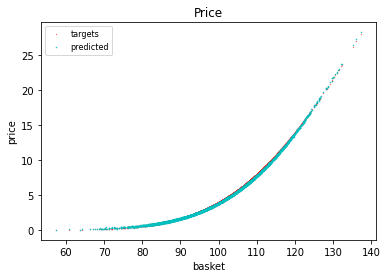

In [77]:
fig, ax = plt.subplots()

ax.set(xlabel='basket', ylabel='price',
       title='Price')

# ax.plot(xp[(xp<xlim)&(yp<ylim*1.2)]*100, yp[(xp<xlim)&(yp<ylim*1.2)]*100, 'co', markersize=2, markerfacecolor='white', label="Pathwise payouts $T_2$")
ax.plot(xAxis*100, yTest*100, 'r.', markersize=0.5, label='targets' )
ax.plot(xAxis*100, y_pred*100, 'co', \
              markersize=0.5, markerfacecolor='white', label="predicted")

# simultated input paths vs BS ground truth
ax.legend(prop={'size': 8}, loc='upper left')


plt.show()


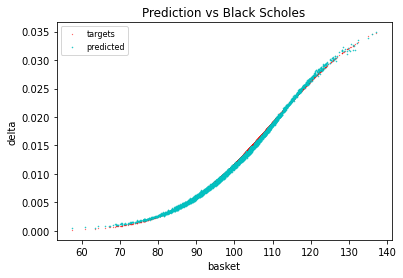

In [78]:
fig, ax = plt.subplots()

ax.set(xlabel='basket', ylabel='delta',
       title='Prediction vs Black Scholes')

# ax.plot(xp[(xp<xlim)&(yp<ylim*1.2)]*100, yp[(xp<xlim)&(yp<ylim*1.2)]*100, 'co', markersize=2, markerfacecolor='white', label="Pathwise payouts $T_2$")
deltidx=0
ax.plot(xAxis*100, dydxTest[:,deltidx],  'r.', markersize=0.5, label='targets')

ax.plot(xAxis*100, dydx_pred[:,deltidx], 'co', markersize=0.5, markerfacecolor='white', label="predicted")

# simultated input paths vs BS ground truth
ax.legend(prop={'size': 8}, loc='upper left')


plt.show()


### Feature extraction

Feature extraction from functional models (see Tensorflow [Guide](https://www.tensorflow.org/guide/keras/functional#extract_and_reuse_nodes_in_the_graph_of_layers))

In [ ]:
normalizer_model = tf.keras.Model(inputs=fw_model.input, outputs = fw_model.layers[1].output)
x_normalized = normalizer_model(xp)

In [ ]:
def normalizer_inv(normalizer, data):
  return (data * np.sqrt(normalizer.variance.numpy())) + normalizer.mean.numpy()
# x_normalized = normalizer_inv(fw_model.layers[1],x_normalized)

In [ ]:
fig, ax = plt.subplots()
ax.set(xlabel='stock S($T_1$)', ylabel='value',
       title='Normalizer layer')
ax.plot(xp, x_normalized, 'co', markersize=2, markerfacecolor='white', label="Pathwise payouts $T_2$")
ax.legend(prop={'size': 8}, loc='upper left')


plt.show()


In [ ]:
features_list = [layer.output for layer in fw_model.layers]
feat_extraction_model = keras.Model(inputs=fw_model.input, outputs=features_list)

In [ ]:
[t.numpy() for t in feat_extraction_model(1.5)]

In [ ]:
fw_model.weights

# Part III : Learning Pricing and Risk Functions from LSM samples

## Gaussian basket options

The recent success of deep learning is largely due to their ability to break the long standing *curse of dimensionality* that breaks classic regression models in high dimension. Contrarily to classic linear models, neural networks don't regress on a fixed set of basis functions. They *learn from data* a relevant regression basis in their hidden layers, embedding a powerful dimension reduction capability in their structure. This is why deep learning succeeded in such high dimensional tasks as computer vision, where the dimension of the inputs is the number of pixels in a picture. Convolutional nets effectively learn the low dimensional features that matter to e.g. image recognition, something a classic regression model couldn't do.

*Differential* machine learning also shines in high dimension, where differential labels help identify relevant features more effectively. In fact, the additional performance from differential training exponentially increases with dimension. This is why twin networks are particularly effective for learning values of complex transactions or trading books as functions of a high dimensional state. 

To illustrate this ability in a simple context, we extend the Black & Scholes example to a basket option written on $n$ correlated stocks. In place of the Black & Scholes model, the stocks are simulated in Bachelier's Gaussian model, where the true price of the basket option is known in closed form, and given by Bachelier's formula applied to the basket at $T_1$. Therefore, we can monitor the performance of our approximators by comparison to the correct, analytic  prices and deltas.

In addition, the example is particularly interesting because *the price is really a non-linear function of the one-dimensional basket*. We expect the machine to learn that from data, and twin networks achieve this a lot better than feedforward networks. The stellar results of the section 3.1 of the article demonstrate the power of differential learning. 

The code below follows the exact same logic as the *BlackScholes* simulator to simulate LSM samples for a basket option in a $n$-dimensional, correlated Bachlier model. The correlations, volatility and basket weights are re-generated randomly on every run, allowing to verify performance in multiple configurations. It is a direct extension of the *BlackScholes* simulator and, as such, such be rather self explanatory.

In [53]:
# helper analytics
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape(-1,1), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        np.random.seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * np.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = np.random.uniform(low=adj_lower, high = adj_upper, size=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    

In [58]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    
    print("done")
    
    predvalues = {}    
    preddeltas = {}


    for size in sizes:   

        
        
        print("\nsize %d" % size)
        derivsMSE = WeightedMSE() # weight calibration follows with training / training data
        model = build_model(xTrain.shape[1], derivLossFn=derivsMSE,  weight_seed=weightSeed, lam=1)
        t0 = time.time()
        history, x_norm, y_norm = train_model(model, xTrain, yTrain, dydxTrain, derivsMSE)       
        y_pred, dydx_pred = predict_unscaled(model, x_norm, y_norm, xTest) 
        predvalues[("standard", size)] = y_pred
        preddeltas[("standard", size)] = dydx_pred[:, deltidx]
        t1 = time.time()
        

        derivsMSE = WeightedMSE() # weight calibration follows with training / training data
        model = build_model(xTrain.shape[1], derivLossFn=derivsMSE,  weight_seed=weightSeed, lam=1)
        t0 = time.time()
        history, x_norm, y_norm = train_model(model, xTrain, yTrain, dydxTrain, derivsMSE)       
        y_pred, dydx_pred = predict_unscaled(model, x_norm, y_norm, xTest) 
        predvalues[("differential", size)] = y_pred
        preddeltas[("differential", size)] = dydx_pred[:, deltidx]
        t1 = time.time()
    
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()


We can reuse our testing functions without modification, starting with dimension 1, where the basket is a European call, priced in the Bachelier model, very similar to Black & Scholes. Unsurprisingly, the results are identical.

In [81]:
# basket / bachelier dimension
basketDim = 2

# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = 12345 #None
weightSeed = 12345 #None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 6860
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024




size 8192


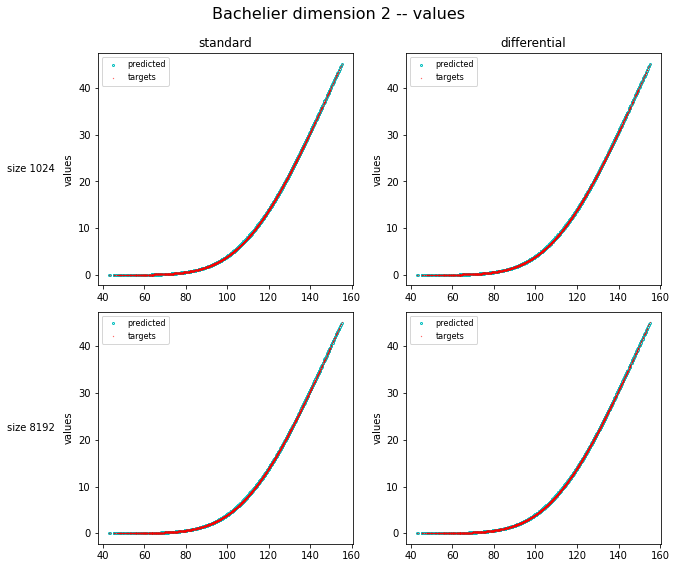

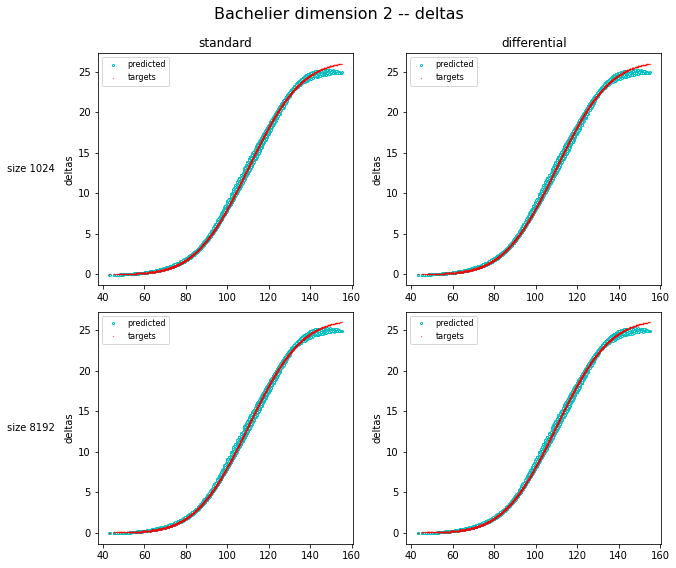

In [82]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, computeRmse=False)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, computeRmse=False)

Moving on to the dimension 7 of the article, we display predictions and correct values as a function of the underlying basket at $T_1$, for 4096 independent examples. The thickness of the plot measures the ability to learn from data that the value is a fixed function of the current undelying basket. A thin curve reflects that this property is correctly learned. A thick line means that the approximator predicts different values for different sets of stocks corresponding to the same basket, hence, failing to learn the pricing function correctly.

In [62]:
# basket / bachelier dimension
basketDim = 7

# simulation set sizes to perform
sizes = [4096, 8192, 16384]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 6662
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096




size 8192




size 16384


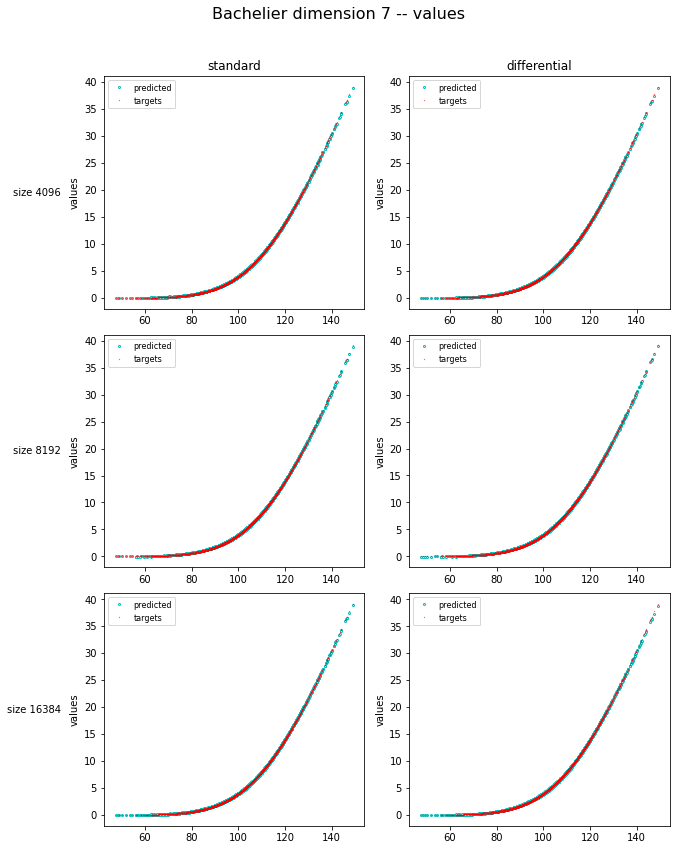

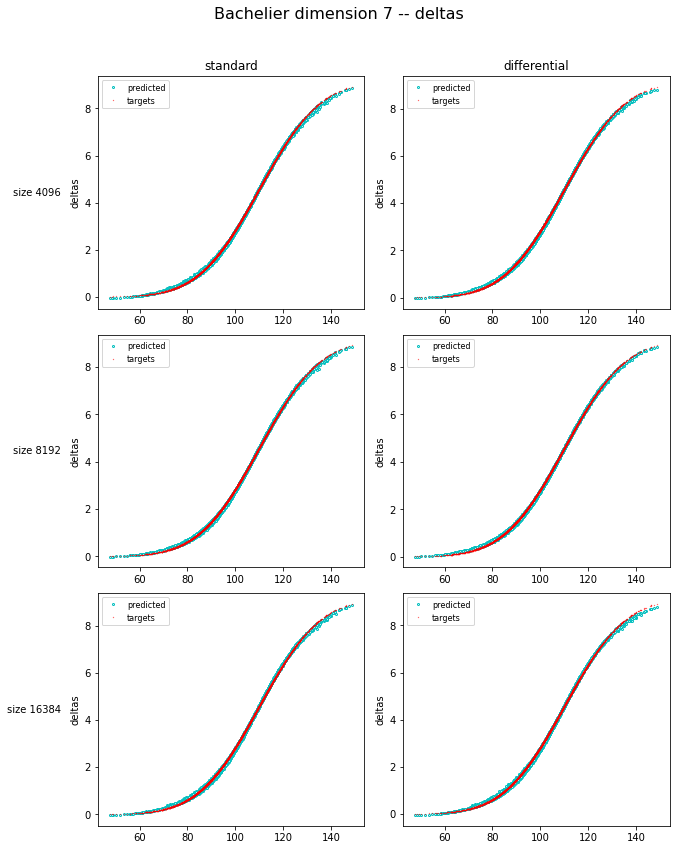

In [64]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, computeRmse=False)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, computeRmse=False)

We reproduce the result of the article where both networks converge to a correct approximation, but differential training gets there orders of magnitude faster, and especially outperforms on smaller training sets. This is what makes it so particularly relevant for the risk management of financial Derivatives.

Below, we test dimension 20. Notice that learning time is virtually unaffected by dimension, and that the performance of the twin network is resilient to high dimensionality, where the standard network starts to struggle. 

Our simple implementation correctly works in dimension up to 30 something. The more thorough data preparation discussed in [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App2-Preprocessing.pdf) in necessary for higher dimensions. 

In [83]:
# basket / bachelier dimension
basketDim = 20

# simulation set sizes to perform
sizes = [4096, 8192, 16384]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 5129
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096




size 8192




size 16384


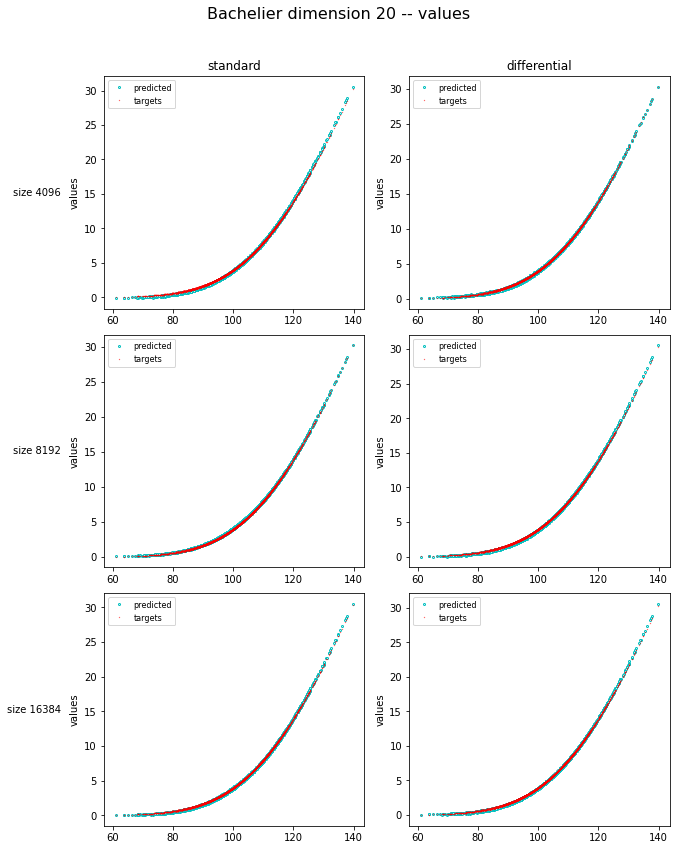

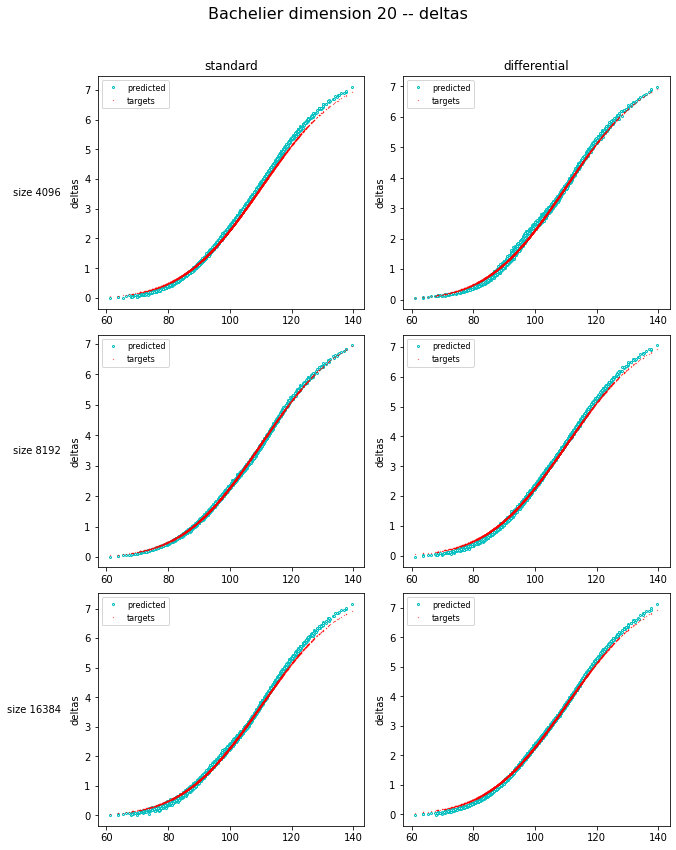

In [84]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, computeRmse=False)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, computeRmse=False)